## 라이브러리 임포트

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import (
    WordCloud, 
    STOPWORDS,
    )
import re

## 데이터 로드

In [2]:
csv_path = 'materials/data_engineering_course_materials/missions/W2/training.1600000.processed.noemoticon.csv'
df = pd.read_csv(csv_path, encoding='latin-1', header=None)
df

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
...,...,...,...,...,...,...
1599995,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599996,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599997,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599998,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...


In [3]:
print(df.isnull().sum())
df.info()

0    0
1    0
2    0
3    0
4    0
5    0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   0       1600000 non-null  int64 
 1   1       1600000 non-null  int64 
 2   2       1600000 non-null  object
 3   3       1600000 non-null  object
 4   4       1600000 non-null  object
 5   5       1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


### 데이터 설명

- target: the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)

- ids: The id of the tweet ( 2087)

- date: the date of the tweet (Sat May 16 23:58:44 UTC 2009)

- flag: The query (lyx). If there is no query, then this value is NO_QUERY.

- user: the user that tweeted (robotickilldozr)

- text: the text of the tweet (Lyx is cool)

## 헤더 부착

In [4]:
df = df.rename({0: 'target', 1: 'ids', 2: 'date', 3: 'flag', 4: 'user', 5: 'text'}, axis=1)
df.columns

Index(['target', 'ids', 'date', 'flag', 'user', 'text'], dtype='object')

## 데이터 탐색

In [5]:
print(df['flag'].value_counts())
print(df['flag'].value_counts())
# 동일한 id 존재
print(df['ids'].value_counts())
# PDT: Pacific Daylight Time: UTC-7
print(df['date'].value_counts())

flag
NO_QUERY    1600000
Name: count, dtype: int64
flag
NO_QUERY    1600000
Name: count, dtype: int64
ids
2190457769    2
1972193428    2
1989776729    2
1989776908    2
1564543229    2
             ..
2197311196    1
2197311146    1
2197310899    1
2197310477    1
2193602129    1
Name: count, Length: 1598315, dtype: int64
date
Mon Jun 15 12:53:14 PDT 2009    20
Fri May 29 13:40:04 PDT 2009    17
Fri May 22 05:10:17 PDT 2009    17
Mon Jun 15 13:39:50 PDT 2009    17
Fri Jun 05 14:13:07 PDT 2009    16
                                ..
Sun Jun 07 12:36:07 PDT 2009     1
Sun Jun 07 12:36:04 PDT 2009     1
Sun Jun 07 12:36:03 PDT 2009     1
Sun Jun 07 12:36:02 PDT 2009     1
Tue Jun 16 08:40:50 PDT 2009     1
Name: count, Length: 774363, dtype: int64


## 중복되는 ids 제거

- 제거하는 이유는 160만개 데이터 중 약 0.21퍼센트인 3370개만 중복되는 ids가 있기 때문에 모두 제거해도 큰 영향을 미치지 않을 것으로 판단됨

In [6]:
print("id unique한 것 개수",df['ids'].nunique())
print("총 row 수", df.shape[0])
print("중복되는 row 개수",(df.shape[0] - df['ids'].nunique()) * 2)
print(f"중복되는 id 퍼센트: {(1 - df['ids'].nunique() / df.shape[0]) * 100 * 2:.2f}%")

df = df.drop_duplicates(subset='ids', keep=False)

id unique한 것 개수 1598315
총 row 수 1600000
중복되는 row 개수 3370
중복되는 id 퍼센트: 0.21%


## 데이터 긍정, 부정 묶기

In [7]:

# @유저이름 Clean Me 등도 존재. 이것도 제거하면 좋음.

groupby_target = df[["target", "ids","text"]].groupby('target').agg({
    'text': " ".join    # 이후에 문제가 될지 모름.
})
groupby_target

,text
target,
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
4,I LOVE @Health4UandPets u guys r the best!! i...


## WordCloud

### cleansing

In [8]:
# @ mentions 제거 
at_ptrn = re.compile(r'\@\w+') # 영어 알파벳, 숫자, 언더스코어(_).
url_ptrn = re.compile(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
# ?: non capturing group: 캡처한 것을 메모리에 저장하지 않음. 재참조할 필요가 없기 때문.
# %는 인코딩된 문자열을 의미함.


# 너무 문자열이 큰 경우 오버헤드 가능성 있음
groupby_target['text'] = groupby_target['text'] \
                            .apply(lambda x: at_ptrn.sub('', x)) \
                            .apply(lambda x: url_ptrn.sub('', x))
groupby_target

,text
target,
0,"- Awww, that's a bummer. You shoulda got Da..."
4,I LOVE u guys r the best!! im meeting up wit...


In [9]:
STOPWORDS, len(STOPWORDS)

({'a',
  'about',
  'above',
  'after',
  'again',
  'against',
  'all',
  'also',
  'am',
  'an',
  'and',
  'any',
  'are',
  "aren't",
  'as',
  'at',
  'be',
  'because',
  'been',
  'before',
  'being',
  'below',
  'between',
  'both',
  'but',
  'by',
  'can',
  "can't",
  'cannot',
  'com',
  'could',
  "couldn't",
  'did',
  "didn't",
  'do',
  'does',
  "doesn't",
  'doing',
  "don't",
  'down',
  'during',
  'each',
  'else',
  'ever',
  'few',
  'for',
  'from',
  'further',
  'get',
  'had',
  "hadn't",
  'has',
  "hasn't",
  'have',
  "haven't",
  'having',
  'he',
  "he'd",
  "he'll",
  "he's",
  'hence',
  'her',
  'here',
  "here's",
  'hers',
  'herself',
  'him',
  'himself',
  'his',
  'how',
  "how's",
  'however',
  'http',
  'i',
  "i'd",
  "i'll",
  "i'm",
  "i've",
  'if',
  'in',
  'into',
  'is',
  "isn't",
  'it',
  "it's",
  'its',
  'itself',
  'just',
  'k',
  "let's",
  'like',
  'me',
  'more',
  'most',
  "mustn't",
  'my',
  'myself',
  'no',
  'nor',

In [16]:
neg_wc = WordCloud(stopwords=STOPWORDS, background_color='white').generate(groupby_target.loc[0, 'text']) 
pos_wc = WordCloud(stopwords=STOPWORDS, background_color='white').generate(groupby_target.loc[4, 'text'])
print(neg_wc)

In [17]:
neg_wc.words_

{'work': 1.0,
 'now': 0.931324868622907,
 'want': 0.8700590788915363,
 'going': 0.840780755295884,
 'today': 0.7496817573522212,
 'go': 0.7449815582465646,
 'miss': 0.724320266344616,
 'got': 0.6673956327316644,
 'know': 0.6651108137219701,
 'quot': 0.6543721643764077,
 'wish': 0.6465384992003134,
 'need': 0.6437640761171133,
 'think': 0.6325684629696119,
 'still': 0.5983614583673336,
 'one': 0.586447759245357,
 'lol': 0.560139700362307,
 'sad': 0.5479648790677939,
 'day': 0.5374547116232007,
 'u': 0.5141821979958874,
 'sorry': 0.5087965531873225,
 'back': 0.5007017658386917,
 'amp': 0.49962463687697883,
 'time': 0.49430427261154813,
 'love': 0.49273753957632926,
 'make': 0.47266377256258774,
 'hate': 0.4712602408852042,
 'see': 0.46499330874432876,
 'will': 0.4557561118908509,
 'feel': 0.43274472043607404,
 'much': 0.4247152136305774,
 'sleep': 0.41342167966837484,
 'hope': 0.4084603583901818,
 'good': 0.34784737409015243,
 'though': 0.34631328132650063,
 'bad': 0.34487710937755,
 'be

In [18]:
pos_wc.words_

{'love': 1.0,
 'quot': 0.8449436991541404,
 'thank': 0.8156618716663973,
 'lol': 0.6698184365066537,
 'going': 0.636603631269867,
 'now': 0.5906201174505684,
 'know': 0.5567587953235278,
 'today': 0.5132535962502021,
 'see': 0.5043639890092129,
 'got': 0.48566887559937505,
 'think': 0.4782339313614568,
 'amp': 0.472226711922849,
 'one': 0.4680243521361996,
 'u': 0.4640374979796347,
 'will': 0.4265933947524379,
 'go': 0.4254889283982544,
 'haha': 0.4182694897904208,
 'work': 0.415602607618124,
 'time': 0.40159474166262593,
 'hope': 0.398685415656484,
 'day': 0.3830073810678304,
 'make': 0.3406605247562093,
 'well': 0.34057971014492755,
 'need': 0.3388826033080114,
 'twitter': 0.32724529928344376,
 'want': 0.3177091751522009,
 'fun': 0.31474597273853777,
 'back': 0.313722320995636,
 'good': 0.30219276978611065,
 'awesome': 0.27907979095953883,
 'nice': 0.27237217822315607,
 'much': 0.262027907979096,
 'still': 0.2595765314368838,
 'way': 0.25901082915791174,
 'great': 0.254512149129896,


### Positive, Negative WordCloud

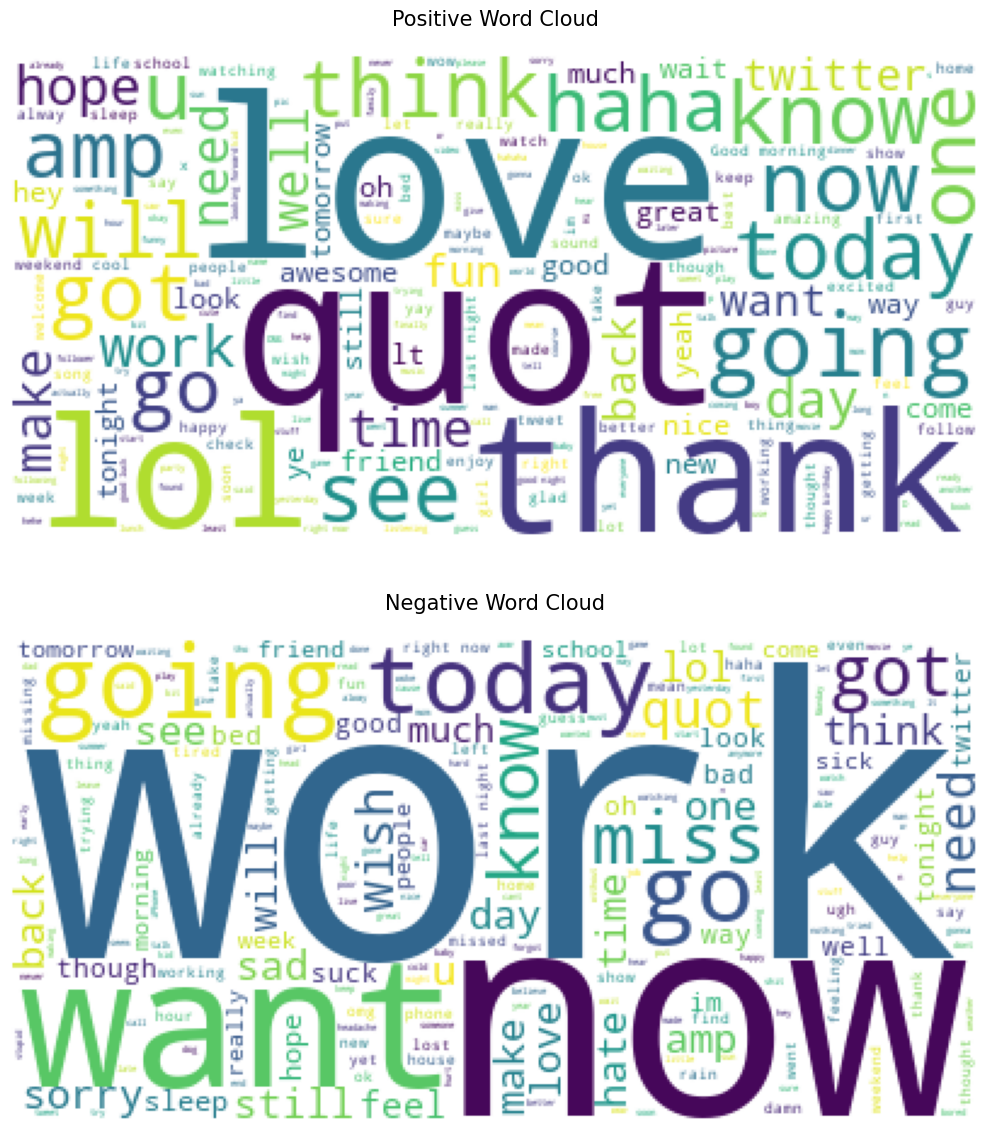

In [19]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))


ax1.imshow(pos_wc)   # wordcloud 객체를 넣으면 워드클라우드 형태의 그래프 생성
ax1.set_title('Positive Word Cloud', pad=20, size=15)
ax1.axis('off')  #눈금 삭제 

ax2.imshow(neg_wc)   # wordcloud 객체를 넣으면 워드클라우드 형태의 그래프 생성
ax2.axis('off')  #눈금 삭제 
ax2.set_title('Negative Word Cloud', pad=20, size=15)

plt.tight_layout()

plt.show()